In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, adjusted_rand_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
CONFIG = {
    'sample_rate': 22050, 'duration': 30, 'n_mels': 128, 'n_mfcc': 40,
    'n_fft': 2048, 'hop_length': 512, 'max_samples_per_class': 50,
    'fixed_time_steps': 128,  # Fixed time dimension for CNN
}
BASE_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\Datasets"
BANGLA_PATH = os.path.join(BASE_PATH, "Bangla_Datasets")
ENGLISH_PATH = os.path.join(BASE_PATH, "English_Datasets")
METADATA_PATH = os.path.join(BASE_PATH, "updated_metadata.csv")
OUTPUT_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\processed_data"
RESULTS_PATH = r"f:\BRACU\Semester 12 Final\CSE425\FInal_project\results_advanced"
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)
print("Configuration loaded!")
print("Loading metadata with lyrics...")
metadata_df = pd.read_csv(METADATA_PATH)
print(f"Metadata shape: {metadata_df.shape}")
print(f"Columns: {metadata_df.columns.tolist()}")
lyrics_dict = dict(zip(metadata_df['ID'], metadata_df['lyrics'].fillna('')))
print(f"Loaded {len(lyrics_dict)} lyrics entries")

Configuration loaded!
Loading metadata with lyrics...
Metadata shape: (1859, 4)
Columns: ['ID', 'language', 'genre', 'lyrics']
Loaded 1859 lyrics entries


In [3]:
def load_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=CONFIG['sample_rate'], duration=CONFIG['duration'])
        expected = CONFIG['sample_rate'] * CONFIG['duration']
        if len(audio) < expected:
            audio = np.pad(audio, (0, expected - len(audio)))
        return audio, sr
    except Exception as e:
        return None, None

def extract_mel_spectrogram(audio, sr):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=CONFIG['n_mels'],
                                          n_fft=CONFIG['n_fft'], hop_length=CONFIG['hop_length'])
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Resize to fixed time steps
    if mel_db.shape[1] > CONFIG['fixed_time_steps']:
        mel_db = mel_db[:, :CONFIG['fixed_time_steps']]
    else:
        mel_db = np.pad(mel_db, ((0, 0), (0, CONFIG['fixed_time_steps'] - mel_db.shape[1])))
    return mel_db

def extract_mfcc(audio, sr):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=CONFIG['n_mfcc'],
                                 n_fft=CONFIG['n_fft'], hop_length=CONFIG['hop_length'])
    if mfcc.shape[1] > CONFIG['fixed_time_steps']:
        mfcc = mfcc[:, :CONFIG['fixed_time_steps']]
    else:
        mfcc = np.pad(mfcc, ((0, 0), (0, CONFIG['fixed_time_steps'] - mfcc.shape[1])))
    return mfcc

print("Audio extraction functions defined!")

# ============================================================================
# CELL 5: Lyrics Embedding Function
# ============================================================================
def create_lyrics_embeddings(lyrics_list, max_features=100):
    """Create TF-IDF embeddings for lyrics."""
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
    # Handle empty lyrics
    lyrics_cleaned = [l if l and len(str(l)) > 0 else ' ' for l in lyrics_list]
    embeddings = vectorizer.fit_transform(lyrics_cleaned).toarray()
    return embeddings, vectorizer

print("Lyrics embedding function defined!")

# ============================================================================
# CELL 6: Collect and Process Audio Files
# ============================================================================
def collect_audio_files():
    audio_files = []
    for path, lang in [(BANGLA_PATH, 'bn'), (ENGLISH_PATH, 'en')]:
        if os.path.exists(path):
            for genre in os.listdir(path):
                genre_path = os.path.join(path, genre)
                if os.path.isdir(genre_path):
                    files = [f for f in os.listdir(genre_path) if f.endswith('.wav')][:CONFIG['max_samples_per_class']]
                    for f in files:
                        file_id = os.path.splitext(f)[0]
                        audio_files.append({
                            'path': os.path.join(genre_path, f),
                            'language': lang, 'genre': genre,
                            'filename': f, 'id': file_id,
                            'lyrics': lyrics_dict.get(file_id, '')
                        })
    return audio_files

audio_files = collect_audio_files()
print(f"Collected {len(audio_files)} audio files")


Audio extraction functions defined!
Lyrics embedding function defined!
Collected 750 audio files


In [4]:
print("\nExtracting features...")
mel_spectrograms, mfccs, labels, lyrics_list, file_metadata = [], [], [], [], []

for file_info in tqdm(audio_files, desc="Processing"):
    audio, sr = load_audio(file_info['path'])
    if audio is not None:
        try:
            mel_spectrograms.append(extract_mel_spectrogram(audio, sr))
            mfccs.append(extract_mfcc(audio, sr))
            labels.append(file_info['genre'])
            lyrics_list.append(file_info['lyrics'])
            file_metadata.append(file_info)
        except:
            pass

mel_spectrograms = np.array(mel_spectrograms)
mfccs = np.array(mfccs)
labels = np.array(labels)
print(f"\nMel spectrograms shape: {mel_spectrograms.shape}")
print(f"MFCCs shape: {mfccs.shape}")

# Create lyrics embeddings
lyrics_embeddings, tfidf_vectorizer = create_lyrics_embeddings(lyrics_list)
print(f"Lyrics embeddings shape: {lyrics_embeddings.shape}")

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(f"Classes: {label_encoder.classes_}")


Extracting features...


Processing: 100%|██████████| 750/750 [01:13<00:00, 10.19it/s]



Mel spectrograms shape: (750, 128, 128)
MFCCs shape: (750, 40, 128)
Lyrics embeddings shape: (750, 100)
Classes: ['Folk' 'Hiphop' 'Indie' 'Metal' 'Pop' 'Rock' 'blues' 'country' 'disco'
 'hiphop' 'jazz' 'metal' 'pop' 'reggae' 'rock']


In [5]:
class ConvVAE(nn.Module):
    def __init__(self, input_channels=1, input_height=128, input_width=128, latent_dim=64):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
        )
        
        # Calculate flattened size
        self.flat_size = 256 * (input_height // 16) * (input_width // 16)
        self.fc_mu = nn.Linear(self.flat_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_size, latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flat_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, 3, stride=2, padding=1, output_padding=1),
        )
        self.h_out = input_height // 16
        self.w_out = input_width // 16

    def encode(self, x):
        h = self.encoder(x).view(-1, self.flat_size)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        h = self.fc_decode(z).view(-1, 256, self.h_out, self.w_out)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar, z

    def get_latent(self, x):
        mu, _ = self.encode(x)
        return mu

print("Convolutional VAE defined!")

Convolutional VAE defined!


In [6]:
class HybridVAE(nn.Module):
    def __init__(self, audio_latent_dim=32, lyrics_dim=100, combined_latent_dim=48):
        super(HybridVAE, self).__init__()
        self.combined_latent_dim = combined_latent_dim
        
        # Audio encoder (from ConvVAE)
        self.audio_encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
        )
        self.audio_flat = 128 * 16 * 16
        self.audio_fc = nn.Linear(self.audio_flat, audio_latent_dim)
        
        # Lyrics encoder
        self.lyrics_encoder = nn.Sequential(
            nn.Linear(lyrics_dim, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, audio_latent_dim), nn.ReLU()
        )
        
        # Combined latent space
        combined_input = audio_latent_dim * 2
        self.fc_mu = nn.Linear(combined_input, combined_latent_dim)
        self.fc_logvar = nn.Linear(combined_input, combined_latent_dim)
        
        # Decoder (audio only)
        self.fc_decode = nn.Linear(combined_latent_dim, self.audio_flat)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        )

    def encode(self, audio, lyrics):
        audio_h = self.audio_encoder(audio).view(-1, self.audio_flat)
        audio_feat = self.audio_fc(audio_h)
        lyrics_feat = self.lyrics_encoder(lyrics)
        combined = torch.cat([audio_feat, lyrics_feat], dim=1)
        return self.fc_mu(combined), self.fc_logvar(combined)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def forward(self, audio, lyrics):
        mu, logvar = self.encode(audio, lyrics)
        z = self.reparameterize(mu, logvar)
        h = self.fc_decode(z).view(-1, 128, 16, 16)
        recon = self.decoder(h)
        return recon, mu, logvar, z

    def get_latent(self, audio, lyrics):
        mu, _ = self.encode(audio, lyrics)
        return mu

print("Hybrid VAE defined!")

Hybrid VAE defined!


In [7]:

def vae_loss(recon, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

class EarlyStopping:
    def __init__(self, patience=15):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return True  # Improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False  # Not improved

print("Loss function and early stopping defined!")

Loss function and early stopping defined!


In [8]:
# Normalize spectrograms
scaler = StandardScaler()
mel_flat = mel_spectrograms.reshape(len(mel_spectrograms), -1)
mel_normalized = scaler.fit_transform(mel_flat).reshape(mel_spectrograms.shape)

# Add channel dimension
X_audio = torch.FloatTensor(mel_normalized).unsqueeze(1)  # (N, 1, H, W)
X_lyrics = torch.FloatTensor(lyrics_embeddings)

print(f"Audio tensor shape: {X_audio.shape}")
print(f"Lyrics tensor shape: {X_lyrics.shape}")

# Create dataset
dataset = TensorDataset(X_audio, X_lyrics)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Audio tensor shape: torch.Size([750, 1, 128, 128])
Lyrics tensor shape: torch.Size([750, 100])


In [9]:
print("\n" + "="*60)
print("TRAINING CONVOLUTIONAL VAE")
print("="*60)

conv_vae = ConvVAE(input_channels=1, input_height=128, input_width=128, latent_dim=64).to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)
early_stop = EarlyStopping(patience=15)

train_losses, val_losses = [], []
epochs = 150

for epoch in range(epochs):
    conv_vae.train()
    train_loss = 0
    for batch in train_loader:
        audio, _ = batch[0].to(device), batch[1].to(device)
        recon, mu, logvar, z = conv_vae(audio)
        loss, _, _ = vae_loss(recon, audio, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    conv_vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            audio = batch[0].to(device)
            recon, mu, logvar, z = conv_vae(audio)
            loss, _, _ = vae_loss(recon, audio, mu, logvar)
            val_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Train={train_losses[-1]:.4f}, Val={val_losses[-1]:.4f}")
    
    if early_stop(val_losses[-1]):
        torch.save(conv_vae.state_dict(), os.path.join(RESULTS_PATH, 'conv_vae_best.pth'))
    
    if early_stop.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

conv_vae.load_state_dict(torch.load(os.path.join(RESULTS_PATH, 'conv_vae_best.pth')))


TRAINING CONVOLUTIONAL VAE
Epoch 10: Train=0.8021, Val=0.6938
Epoch 20: Train=0.7434, Val=0.6922
Epoch 30: Train=0.7280, Val=0.6229
Epoch 40: Train=0.7109, Val=0.6196
Epoch 50: Train=0.6897, Val=0.5948
Epoch 60: Train=0.6797, Val=0.5789
Epoch 70: Train=0.6674, Val=0.5704
Epoch 80: Train=0.6563, Val=0.5780
Epoch 90: Train=0.6655, Val=0.5679
Epoch 100: Train=0.6754, Val=0.5728
Epoch 110: Train=0.6483, Val=0.5700
Early stopping at epoch 118


<All keys matched successfully>

In [10]:
print("\n" + "="*60)
print("TRAINING HYBRID VAE (Audio + Lyrics)")
print("="*60)

hybrid_vae = HybridVAE(audio_latent_dim=32, lyrics_dim=100, combined_latent_dim=48).to(device)
optimizer = optim.Adam(hybrid_vae.parameters(), lr=1e-3)
early_stop = EarlyStopping(patience=15)

hybrid_train_losses, hybrid_val_losses = [], []

for epoch in range(epochs):
    hybrid_vae.train()
    train_loss = 0
    for batch in train_loader:
        audio, lyrics = batch[0].to(device), batch[1].to(device)
        recon, mu, logvar, z = hybrid_vae(audio, lyrics)
        loss, _, _ = vae_loss(recon, audio, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    hybrid_vae.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            audio, lyrics = batch[0].to(device), batch[1].to(device)
            recon, mu, logvar, z = hybrid_vae(audio, lyrics)
            loss, _, _ = vae_loss(recon, audio, mu, logvar)
            val_loss += loss.item()
    
    hybrid_train_losses.append(train_loss / len(train_loader))
    hybrid_val_losses.append(val_loss / len(val_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Train={hybrid_train_losses[-1]:.4f}, Val={hybrid_val_losses[-1]:.4f}")
    
    if early_stop(hybrid_val_losses[-1]):
        torch.save(hybrid_vae.state_dict(), os.path.join(RESULTS_PATH, 'hybrid_vae_best.pth'))
    
    if early_stop.early_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

hybrid_vae.load_state_dict(torch.load(os.path.join(RESULTS_PATH, 'hybrid_vae_best.pth')))


TRAINING HYBRID VAE (Audio + Lyrics)
Epoch 10: Train=1.7225, Val=1.4977
Epoch 20: Train=1.0468, Val=0.9143
Epoch 30: Train=0.9317, Val=0.8279
Epoch 40: Train=0.8773, Val=0.7848
Epoch 50: Train=0.8815, Val=0.7472
Epoch 60: Train=0.9104, Val=0.8887
Early stopping at epoch 68


<All keys matched successfully>

In [11]:
print("\n" + "="*60)
print("EXTRACTING LATENT FEATURES")
print("="*60)

conv_vae.eval()
hybrid_vae.eval()

with torch.no_grad():
    audio_all = X_audio.to(device)
    lyrics_all = X_lyrics.to(device)
    conv_latent = conv_vae.get_latent(audio_all).cpu().numpy()
    hybrid_latent = hybrid_vae.get_latent(audio_all, lyrics_all).cpu().numpy()

# PCA baseline
pca = PCA(n_components=48)
pca_features = pca.fit_transform(mel_flat)

print(f"Conv VAE latent: {conv_latent.shape}")
print(f"Hybrid VAE latent: {hybrid_latent.shape}")
print(f"PCA features: {pca_features.shape}")


EXTRACTING LATENT FEATURES
Conv VAE latent: (750, 64)
Hybrid VAE latent: (750, 48)
PCA features: (750, 48)


In [12]:
print("\n" + "="*60)
print("CLUSTERING WITH MULTIPLE ALGORITHMS")
print("="*60)

def evaluate_clustering(features, cluster_labels, true_labels):
    """Evaluate clustering with multiple metrics."""
    n_clusters = len(np.unique(cluster_labels))
    if n_clusters < 2 or n_clusters >= len(features):
        return {'silhouette': -1, 'davies_bouldin': -1, 'calinski': -1, 'ari': -1}
    
    return {
        'silhouette': silhouette_score(features, cluster_labels),
        'davies_bouldin': davies_bouldin_score(features, cluster_labels),
        'calinski': calinski_harabasz_score(features, cluster_labels),
        'ari': adjusted_rand_score(true_labels, cluster_labels)
    }

# Define clustering algorithms
def get_clusterers(n_clusters):
    return {
        'K-Means': KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
        'Agglomerative': AgglomerativeClustering(n_clusters=n_clusters),
        'DBSCAN': DBSCAN(eps=0.5, min_samples=5)
    }

# Test with optimal K (using unique genres)
n_clusters = len(np.unique(labels))
print(f"Number of clusters: {n_clusters}")

# Store results
results = {}
feature_sets = {
    'Conv_VAE': conv_latent,
    'Hybrid_VAE': hybrid_latent,
    'PCA_Baseline': pca_features
}

for feat_name, features in feature_sets.items():
    print(f"\n{feat_name}:")
    results[feat_name] = {}
    
    for clust_name, clusterer in get_clusterers(n_clusters).items():
        try:
            if clust_name == 'DBSCAN':
                # Scale features for DBSCAN
                features_scaled = StandardScaler().fit_transform(features)
                cluster_labels = clusterer.fit_predict(features_scaled)
            else:
                cluster_labels = clusterer.fit_predict(features)
            
            metrics = evaluate_clustering(features, cluster_labels, labels_encoded)
            results[feat_name][clust_name] = metrics
            print(f"  {clust_name}: Sil={metrics['silhouette']:.3f}, DB={metrics['davies_bouldin']:.3f}, ARI={metrics['ari']:.3f}")
        except Exception as e:
            print(f"  {clust_name}: Failed - {e}")
            results[feat_name][clust_name] = None


CLUSTERING WITH MULTIPLE ALGORITHMS
Number of clusters: 15

Conv_VAE:
  K-Means: Sil=0.150, DB=1.457, ARI=0.143
  Agglomerative: Sil=0.111, DB=1.568, ARI=0.117
  DBSCAN: Sil=-1.000, DB=-1.000, ARI=-1.000

Hybrid_VAE:
  K-Means: Sil=0.150, DB=1.557, ARI=0.113
  Agglomerative: Sil=0.117, DB=1.701, ARI=0.100
  DBSCAN: Sil=-1.000, DB=-1.000, ARI=-1.000

PCA_Baseline:
  K-Means: Sil=0.079, DB=2.447, ARI=0.115
  Agglomerative: Sil=0.057, DB=2.632, ARI=0.101
  DBSCAN: Sil=-1.000, DB=-1.000, ARI=-1.000


In [13]:
print("\n" + "="*60)
print("RESULTS COMPARISON")
print("="*60)

# Create comparison DataFrame
comparison_rows = []
for feat_name, clusterings in results.items():
    for clust_name, metrics in clusterings.items():
        if metrics:
            comparison_rows.append({
                'Feature': feat_name, 'Clustering': clust_name,
                'Silhouette': metrics['silhouette'],
                'Davies-Bouldin': metrics['davies_bouldin'],
                'Calinski-Harabasz': metrics['calinski'],
                'Adjusted Rand Index': metrics['ari']
            })

comparison_df = pd.DataFrame(comparison_rows)
print("\n", comparison_df.to_string(index=False))
comparison_df.to_csv(os.path.join(RESULTS_PATH, 'clustering_comparison.csv'), index=False)


RESULTS COMPARISON

      Feature    Clustering  Silhouette  Davies-Bouldin  Calinski-Harabasz  Adjusted Rand Index
    Conv_VAE       K-Means    0.149541        1.456903          81.701794             0.142665
    Conv_VAE Agglomerative    0.111289        1.568490          69.540673             0.116544
    Conv_VAE        DBSCAN   -1.000000       -1.000000          -1.000000            -1.000000
  Hybrid_VAE       K-Means    0.149843        1.556640         114.097270             0.113157
  Hybrid_VAE Agglomerative    0.116738        1.700811          99.393308             0.100346
  Hybrid_VAE        DBSCAN   -1.000000       -1.000000          -1.000000            -1.000000
PCA_Baseline       K-Means    0.079477        2.447498          80.784529             0.114983
PCA_Baseline Agglomerative    0.057305        2.632305          76.345270             0.101432
PCA_Baseline        DBSCAN   -1.000000       -1.000000          -1.000000            -1.000000



t-SNE VISUALIZATION


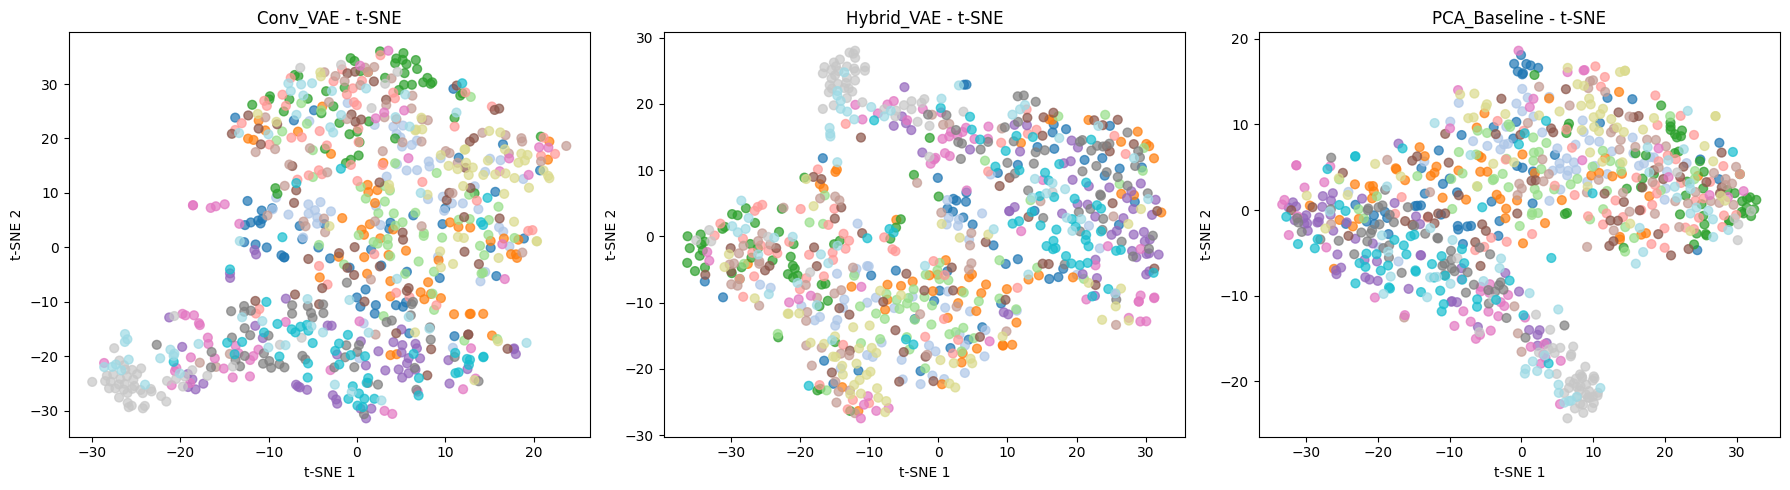

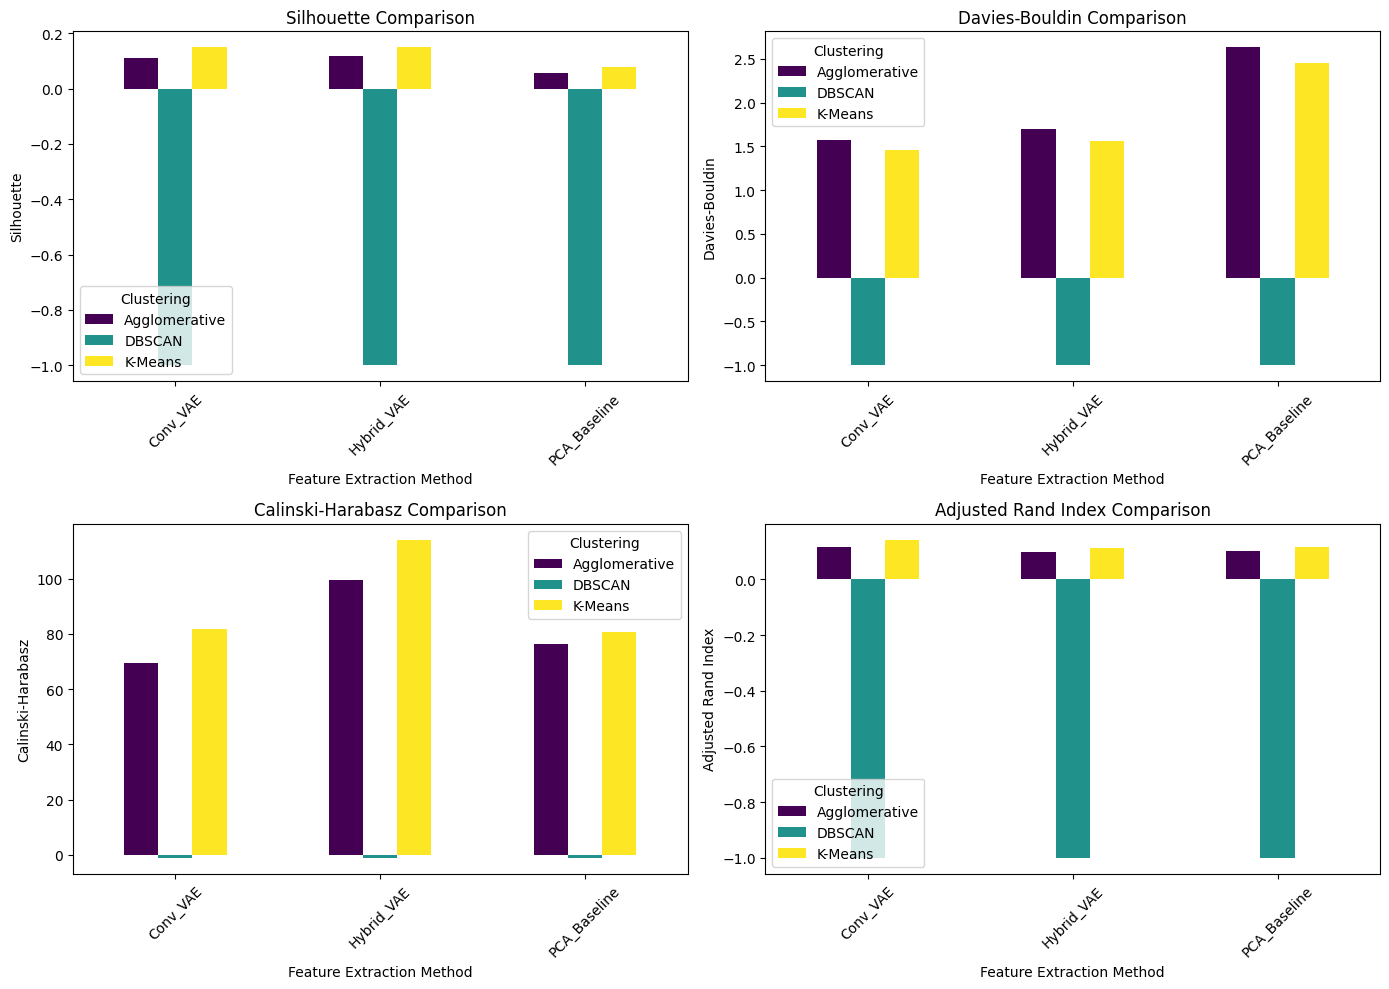

In [14]:
print("\n" + "="*60)
print("t-SNE VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

for idx, (name, features) in enumerate(feature_sets.items()):
    tsne_result = tsne.fit_transform(features)
    scatter = axes[idx].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                                 c=labels_encoded, cmap='tab20', alpha=0.7, s=40)
    axes[idx].set_title(f'{name} - t-SNE')
    axes[idx].set_xlabel('t-SNE 1')
    axes[idx].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_comparison.png'), dpi=150)
plt.show()

# CELL 18: Bar Plot Comparison

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_list = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'Adjusted Rand Index']

for idx, metric in enumerate(metrics_list):
    ax = axes[idx // 2, idx % 2]
    pivot_df = comparison_df.pivot(index='Feature', columns='Clustering', values=metric)
    pivot_df.plot(kind='bar', ax=ax, colormap='viridis')
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Feature Extraction Method')
    ax.set_ylabel(metric)
    ax.legend(title='Clustering')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'metrics_comparison.png'), dpi=150)
plt.show()


t-SNE VISUALIZATION


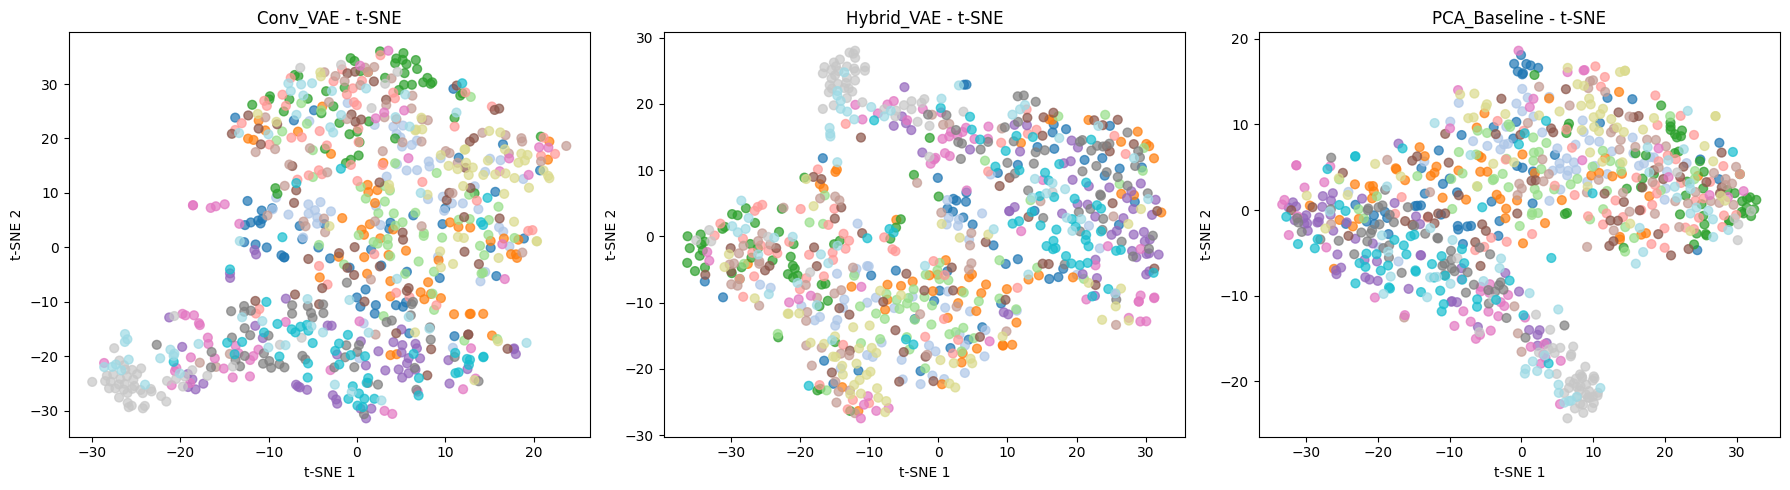

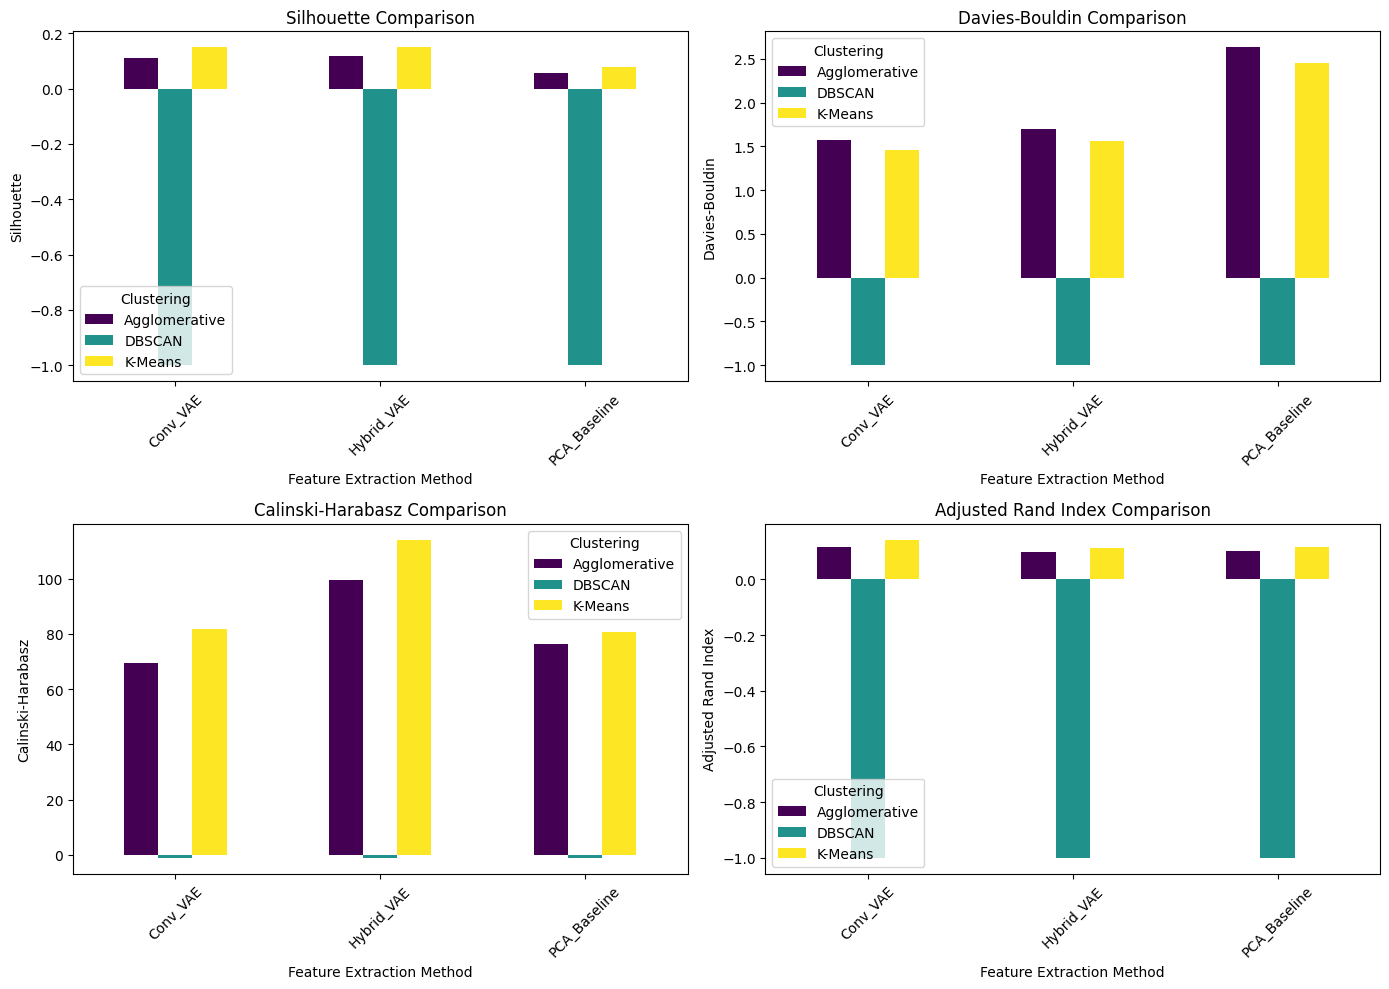

In [15]:
print("\n" + "="*60)
print("t-SNE VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

for idx, (name, features) in enumerate(feature_sets.items()):
    tsne_result = tsne.fit_transform(features)
    scatter = axes[idx].scatter(tsne_result[:, 0], tsne_result[:, 1], 
                                 c=labels_encoded, cmap='tab20', alpha=0.7, s=40)
    axes[idx].set_title(f'{name} - t-SNE')
    axes[idx].set_xlabel('t-SNE 1')
    axes[idx].set_ylabel('t-SNE 2')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'tsne_comparison.png'), dpi=150)
plt.show()

# ============================================================================
# CELL 18: Bar Plot Comparison
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_list = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz', 'Adjusted Rand Index']

for idx, metric in enumerate(metrics_list):
    ax = axes[idx // 2, idx % 2]
    pivot_df = comparison_df.pivot(index='Feature', columns='Clustering', values=metric)
    pivot_df.plot(kind='bar', ax=ax, colormap='viridis')
    ax.set_title(f'{metric} Comparison')
    ax.set_xlabel('Feature Extraction Method')
    ax.set_ylabel(metric)
    ax.legend(title='Clustering')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'metrics_comparison.png'), dpi=150)
plt.show()